# ✨ Tensorflow  image classification
Using tensorflow [image classification tutorial ](https://www.tensorflow.org/tutorials/images/classification)

# ➡️ Imports, dataset downloading and configuring

In [164]:
import matplotlib.pyplot as plt
import numpy as np
import PIL # Preview Images
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib # for downloading dataset

### 🌸 Here i will be using flowers dataset

In [165]:
""" # Folder structure
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
"""

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


In [166]:
# Verify download
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


✔️ Seems that all images from dataset downloaded correctly

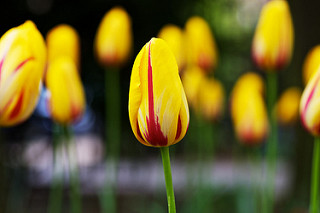

In [167]:
# Check actual images
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


## ⚙️ Keras settings

### 🔧 Properties of dataset images

In [168]:
batch_size = 32
img_height = 180
img_width  = 180

## ✂️ Dataset splits  

### 🎓 Training dataset

In [169]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### ✅ Validation dataset

In [170]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### 📝 Classes ( features )

In [171]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 👀 Visualize data

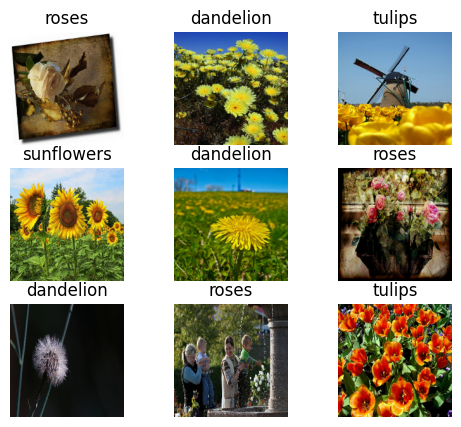

In [172]:
plt.figure(figsize=(6, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[[i]]])
    plt.axis("off")

In [173]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 🧰 Configure dataset

In [174]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 📦 Standardize the data

In [175]:
# For neural network values from 0 to 1 is most optimal
normalization_layer = layers.Rescaling(1./255)

In [176]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
# check pixel values
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9891067


## 🛠️ Data augmentation
##### Generating additional data in dataset because of overfitting

In [177]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

#### 👀 Visualization of Data Augmentation

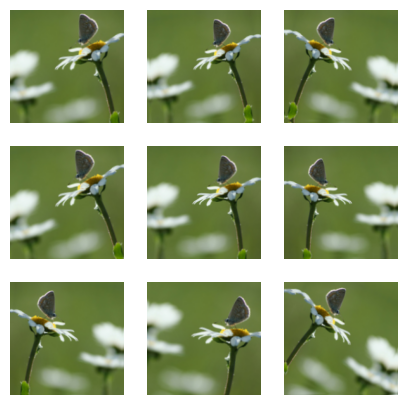

In [178]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 🤖 Keras Model

In [206]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # to decrease overfitting
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile model

In [207]:
model.compile(optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [208]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

## 📥 Train Model

### 🏃‍♀️ Training

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/15
79/92 [========================>.....] - ETA: 9s - loss: 1.4257 - accuracy: 0.3524 

### 📈 Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 🆕 Predict new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file("Red_sunflower", origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f"This is {class_names[np.argmax(score)]}, ({100*np.max(score)})"
)

# 💾 Save model

In [ ]:
# convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)